In [1]:
import cv2
import os
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from os import listdir
from random import choice
from numpy import savez_compressed
from numpy import asarray
from tensorflow.keras.preprocessing import image
from numpy import load as load1
from keras.models import load_model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from joblib import dump, load

Using TensorFlow backend.


In [2]:
def tomarfoto():
    print('Presiona la tecla g para capturar la foto')
    print('Presiona la tecla q para salir')
    cap = cv2.VideoCapture(0)
    fotouser =[]
    while True:
        ret,frame = cap.read()
        if not ret:
            print('Fallo en lectura de la camara')
            break
        key = cv2.waitKey(1)
        if key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
        cv2.imshow('Camera', frame)
        if key == ord('g'):
            fotouser = frame     #Guarda la foto
            print('foto capturada exitosamente')
    return fotouser    # La funcion retorna la foto

In [3]:
def Getear(foto):
    copia = foto
    earClassif = cv2.CascadeClassifier('cascade.xml')
    gray = cv2.cvtColor(copia, cv2.COLOR_BGR2GRAY)
    ear = earClassif.detectMultiScale(gray, scaleFactor=1.07, minNeighbors=10)  ##minNeig se cambia si no reconoce oreja
    out = []
    for (x,y,w,h) in ear:
        out = foto[y-5:y+h+10,x-10:x+w+10]
    plt.title("foto ear")
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")
    plt.imshow(out)
    plt.show()
    return out

In [4]:
def Aumentardatos(ear):
    
    #create image data augmentation generator

    datagenb = ImageDataGenerator(brightness_range=[0.6,1.4])
    datagenr = ImageDataGenerator(rotation_range= (16))
    
    #data = img_to_array(ear)
    samples = expand_dims(ear, 0)
    itb = datagenb.flow(samples, batch_size=1)
    itr = datagenr.flow(samples, batch_size=1)
    
    fotos = list()
    j = 0
    for i in range(30):   #generara tantas como quiera cada iteracion saca una modificacion de la imagen original
        
        z = round(random.uniform(0.94,0.86),3)
        datagenz = ImageDataGenerator(zoom_range=[z,z])        ## Zoom acerca
        a = round(random.uniform(1.02,1.11),3)
        datagena = ImageDataGenerator(zoom_range=[a,a])       ## aleja

        itz = datagenz.flow(samples, batch_size=1)
        ita = datagena.flow(samples, batch_size=1)
        
        # generate batch of images
        batchz = itz.next()
        batcha = ita.next()
        batchr = itr.next()
        batchb = itb.next()
        
        fotos.append(batchz[0].astype('uint8'))
        fotos.append(batcha[0].astype('uint8'))
        fotos.append(batchr[0].astype('uint8'))
        fotos.append(batchb[0].astype('uint8'))
    print('Datos aumentados guardados')
    return fotos

In [6]:
####Embedings#######
# get the ear embedding for one ear
def get_embedding(model, ear_pixels):
    required_size = (160,160)
    ear = cv2.resize(ear_pixels, required_size)   #(160,160)   #oreja lista
    # scale pixel values
    ear = ear.astype('float32')
    # standardize pixel values across channels (global)  #esto es requisito para el modelo Facenet
    mean, std = ear.mean(), ear.std()
    ear = (ear - mean) / std
    # transform ear into one sample
    samples = expand_dims(ear, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [7]:
def AllEmbedings(data, user, code):
    # code es los ultimos 3 digitos de la cedula del usuario
    model  = load_model('facenet_keras.h5')
    Emb    = list()
    Label  = list()
    DataBase = 'DataBase/'
    
    for ear in data:
        emb = get_embedding(model, ear)
        Emb.append(emb)
        Label.append(user)

    savez_compressed(DataBase + code + '.npz', Emb, Label)    ##embedings solo del usuario
    return Emb, Label

In [8]:
def sincro(NtrainE, NlabelsT, NvalE, NlabelsV, Emb,Label):
    # SIncro embedings
    Emb = asarray(Emb)    # Usuario
    
    e = np.concatenate((Emb, NvalE, NtrainE))   #Los embedings de validacion (usuario y negativo)
     ##EL orden es usuario - Negativo

    #Sincro labels
    NlabelsV = NlabelsV.tolist()  # negativo de validacion en lista
    NlabelsT = NlabelsT.tolist()  # negativo de entrenamiento en lista

    l = Label + NlabelsV + NlabelsT   # Une labels de usuario y orejas negativas
    return e, l

In [9]:
def models(e , l, code):
# normalize input vectors      Normaliza cada uno de los embebedings que entratan al clasificador(entrenamiento y validación)
    in_encoder = Normalizer(norm='l2')
    X = in_encoder.transform(e)
    
# label encode targets              (Codifica las etiquetas de cada oreja para entrenar el clasificador)
    out_encoder = LabelEncoder()
    out_encoder.fit(l)
    Y = out_encoder.transform(l)
    ename = code + 'out_encoder.joblib'
    dump(out_encoder,'Modelos/' + ename)            #Guarda este encoder
    print('encoder guardado con éxito')
    
# fit model clasificador                       (Enrena el clasificador con todos los datos de entrenamiento)
    model = SVC(kernel='linear', probability=True)
    model.fit(X, Y)          #(Se le ingresa las orejas y respectivas etiquetas para su entrenamiento)
    cname = code + 'model.joblib'
    dump(model,'Modelos/' + cname)                  #Guarda este clasificador entrenado
    print('clasificador guardado con éxito')

In [10]:
def Rolar():
    print('Ingrese nombre de usuario: ')
    user = input()
    print('ingrese ultimos 3 digitos de la cedula: ')
    code = input()
    foto = tomarfoto()
    ear  = Getear(foto)
    print('¿Continuar? Si : y | No : n')
    conti = input()
    if conti == 'y':
        orejas = Aumentardatos(ear)
        e, l = AllEmbedings(orejas, user, code)
        negative = load1('EmbedingsNegative.npz')
        NtrainE, NlabelsT, NvalE, NlabelsV = negative['arr_0'], negative['arr_1'], negative['arr_2'], negative['arr_3']
        e, l = sincro(NtrainE, NlabelsT, NvalE, NlabelsV, e, l)
        models(e, l, code)

Ingrese nombre de usuario: 
Jose
ingrese ultimos 3 digitos de la cedula: 
723
Presiona la tecla g para capturar la foto
Presiona la tecla q para salir
foto capturada exitosamente


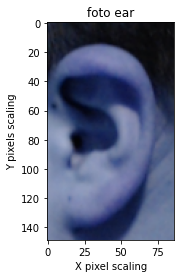

¿Continuar? Si : y | No : n
y
Datos aumentados guardados


C:\Users\JOSE\anaconda3\envs\biometrics\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


encoder guardado con éxito
clasificador guardado con éxito


In [11]:
Rolar()